In [1]:
%load_ext autoreload
%autoreload 2

In [468]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.evaluation import *

import io, requests, glob

from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
from starfish import data
import pprint
import seaborn as sns

import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [21]:
bench_df, code_ref, targets = get_merfish_mop(return_bench_df=True)

17130008


In [4]:
max_p_150 = cpu(read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images150.tif', scaled=True, z_to_batch=True)).max(0).max(0)[0]
max_p_151 = cpu(read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images151.tif', scaled=True, z_to_batch=True)).max(0).max(0)[0]
max_p_47 = cpu(read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images47.tif', scaled=True, z_to_batch=True)).max(0).max(0)[0]

In [407]:
logr_coefs = {'x_sig': 0.03480553, 'y_sig': 0.02517798, 'z_sig': 0.02675353, 'prob': -2.34418526}

In [6]:
fids_150 = get_peaks(max_p_150, 18000, 20)
fids_151 = get_peaks(max_p_151, 18000, 20)
fids_47 = get_peaks(max_p_47, 18000, 20)

In [771]:
select = ['base']#,'bs:20xcrop_sz:56xbl_loss_scale:0.003','crop_sz:56','bs:15','bs:20']

sweep_name = 'sweep_mop_13'
file_nrs = [150,151,47]

out_dir = f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/{sweep_name}/*'
files = glob.glob(out_dir)
base_str = 'bsub -gpu "num=1" -q gpu_rtx -n 3 -o logs/ofish.log -e logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/merfish_eval.py '

with open('run_slurm.sh', 'w') as f:
    for nr in file_nrs:
        for n in files:
            if '9995' in n:
                name = n.split('/')[-1]
                if 'step' not in name:
                    print(name)
                    f.write(base_str + f'run_name={name} sweep_name={sweep_name} file_nr={nr} \n')

In [690]:
# sweep_name = 'sweep_mop_11'
# file_nrs = [151]
# iters = np.arange(1,21)*1500

# out_dir = f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/{sweep_name}/*'
# files = glob.glob(out_dir)
# base_str = 'bsub -gpu "num=1" -q gpu_rtx -n 3 -o logs/ofish.log -e logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/merfish_eval.py '

# with open('run_slurm.sh', 'w') as f:
#     for nr in file_nrs:
#         for n in files:
#             name = n.split('/')[-1]
#             if 'color_shifts:True' in name:
#                 for it in iters:
#                     print(name, it)
#                     f.write(base_str + f'run_name={name} out_id={it} sweep_name={sweep_name} file_nr={nr} \n')
#                     print(base_str + f'run_name={name} out_id={it} sweep_name={sweep_name} file_nr={nr} \n')

In [373]:
def clean_bench_df(bench_df, fids):
    bench_df = nm_to_px((bench_df), [1.085,1.085,1.085])
    bench_df['x'] += 70
    bench_df['y'] += 70
    bench_df = exclude_borders(bench_df, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
    bench_df = remove_fids(bench_df, px_to_nm(fids), tolerance=1000)
    bench_df = remove_doublets(bench_df, tolerance=200)
    return bench_df

def clean_istd_df(bench_df, fids):
    bench_df['loc_idx'] = np.arange(len(bench_df))
    bench_df['gene'] = targets[bench_df['code_inds']]
    bench_df = exclude_borders(bench_df, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
    bench_df = remove_fids(bench_df, px_to_nm(fids), tolerance=1000)
    bench_df = remove_doublets(bench_df, tolerance=200)
    return bench_df

def log_reg(df, weights={}):
    
    df['score'] = 0
    for k in weights:
        df['score'] += weights[k] * df[k]
    df['score'] = 1/(1 + np.exp(-df['score']))
    return df

In [348]:
bench_151

,loc_idx,x,y,z,gene,frame_idx,code_inds
5917974,5917974,112889.723502,73336.359447,0.000000,1810046K07Rik,0,1
5917976,5917976,42838.202765,15395.806452,0.000000,Acta2,0,4
5917977,5917977,106203.179724,26874.792627,0.000000,Acta2,0,4
5917978,5917978,100711.935484,35643.548387,0.000000,Acta2,0,4
5917979,5917979,36199.400922,35710.184332,0.000000,Acta2,0,4
...,...,...,...,...,...,...,...
5962172,5962172,99033.133641,165866.589862,8294.930876,Blank-8,0,249
5962174,5962174,124051.566820,44718.387097,8294.930876,Blank-9,0,250
5962175,5962175,152151.566820,50378.110599,8294.930876,Blank-9,0,250
5962176,5962176,54432.211982,180730.092166,8294.930876,Blank-9,0,250


In [8]:
istd_151 = pd.read_csv('../data/results/MERFISH/istdeco_MOp_151.csv')

In [13]:
istd_151 = clean_istd_df(istd_151, fids_47)

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/emitter_io.py:191: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [344]:
# bench_df, code_ref, targets = get_merfish_mop(return_bench_df=True, z_to_batch=True)
bench_150 = clean_bench_df(get_mop_fov(bench_df, 150), fids_150)
bench_151 = clean_bench_df(get_mop_fov(bench_df, 151), fids_151)
bench_47 = clean_bench_df(get_mop_fov(bench_df, 47), fids_47)

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/emitter_io.py:191: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [109]:
red_df = pd.read_csv(glob.glob(f'../data/results/MERFISH/merfish_sweep_mop_10_*')[0])

In [772]:
df_dict = {'150':{},'151':{},'47':{}}

sweep_name = 'merfish_sweep_mop_13'

for f in glob.glob(f'../data/results/MERFISH/{sweep_name}_*'):
#     if '50000' in f:
    dec_df = pd.read_csv(f)
    print(f, len(dec_df))
    if len(dec_df):
#             dec_df = sel_int_ch(dec_df, code_ref)
        dec_df['zm'] = dec_df['z']%100
        dec_df = exclude_borders(dec_df, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
        if '_47' in f:
            ds = '47'
            dec_df = remove_fids(dec_df, px_to_nm(fids_47), tolerance=1000)
        if '_150' in f:
            ds = '150'
            dec_df = remove_fids(dec_df, px_to_nm(fids_150), tolerance=1000)
        if '_151' in f:
            ds = '151'
            dec_df = remove_fids(dec_df, px_to_nm(fids_151), tolerance=1000)

        dec_df = remove_doublets(dec_df, tolerance=200)
        dec_df = log_reg(dec_df, logr_coefs)
        df_dict[ds][f.split(sweep_name)[-1].split('.csv')[0].split('_None')[0]] = dec_df

../data/results/MERFISH/merfish_sweep_mop_13_seed:3_None_47.csv 82442
../data/results/MERFISH/merfish_sweep_mop_13_seed:1_None_47.csv 77081
../data/results/MERFISH/merfish_sweep_mop_13_seed:0_None_151.csv 47233
../data/results/MERFISH/merfish_sweep_mop_13_seed:0_None_47.csv 84380
../data/results/MERFISH/merfish_sweep_mop_13_seed:3_None_151.csv 44658
../data/results/MERFISH/merfish_sweep_mop_13_seed:0_None_150.csv 37417
../data/results/MERFISH/merfish_sweep_mop_13_seed:1_None_151.csv 40828
../data/results/MERFISH/merfish_sweep_mop_13_seed:3_None_150.csv 35116
../data/results/MERFISH/merfish_sweep_mop_13_seed:1_None_150.csv 31565


In [ ]:
df_dict = {'151':{}}

sweep_name = 'merfish_sweep_mop_11'

for f in glob.glob(f'../data/results/MERFISH/{sweep_name}_*'):
    ds = '151' if '151' in f else '150'
    if ds == '150': continue
    dec_df = pd.read_csv(f)
    dec_df = log_reg(dec_df, logr_coefs)
    df_dict[ds][f.split(sweep_name)[-1].split('.csv')[0]] = dec_df

In [688]:
df_dict['151'].keys()

dict_keys(['_seed:0', '_seed:1'])

In [695]:
names = [k[:-4] for k in df_dict['151'].keys()]
# del(names[2])
omega_df = DF(columns=pd.MultiIndex.from_product([['151'], names+['bench']]), index=['N','N_blanks', 'NN_blanks', 'corr'])
# omega_df.loc['N', '150']['bench'] = len(bench_150)
# omega_df.loc['N_blanks', '150']['bench'] = sum(bench_150['gene'].str.contains('Blank'))
# omega_df.loc['NN_blanks', '150']['bench'] = 1.
omega_df.loc['N', '151']['bench'] = len(bench_151)
omega_df.loc['N_blanks', '151']['bench'] = sum(bench_151['gene'].str.contains('Blank'))
omega_df.loc['NN_blanks', '151']['bench'] = 1.
# omega_df.loc['N', '47']['bench'] = len(bench_47)
# omega_df.loc['N_blanks', '47']['bench'] = sum(bench_47['gene'].str.contains('Blank'))
# omega_df.loc['NN_blanks', '47']['bench'] = 1

for n in ['151']:
    for j in names:
        exp_df = df_dict[n][j+'_'+n]
        omega_df.loc['N', n][j] = len(exp_df)
        omega_df.loc['N_blanks', n][j] = sum(exp_df['gene'].str.contains('Blank'))
        omega_df.loc['NN_blanks', n][j] = sum(exp_df.nsmallest(omega_df.loc['N', n]['bench'], 'score')['gene'].str.contains('Blank'))/omega_df.loc['N_blanks', n]['bench']

KeyError: '_seed_151'

In [693]:
names

['_se', '_se', '_se']

In [684]:
omega_df

151            
           _se  _se  bench
N          NaN  NaN  36464
N_blanks   NaN  NaN     57
NN_blanks  NaN  NaN    1.0
corr       NaN  NaN    NaN

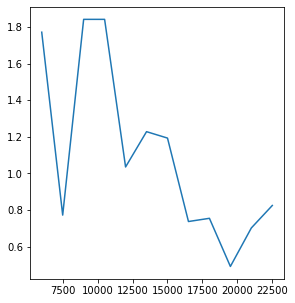

In [370]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(iters[3:-5], omega_df['151'].loc['NN_blanks'][[f'_color_shifts:True_{n}' for n in iters[3:-5]]])

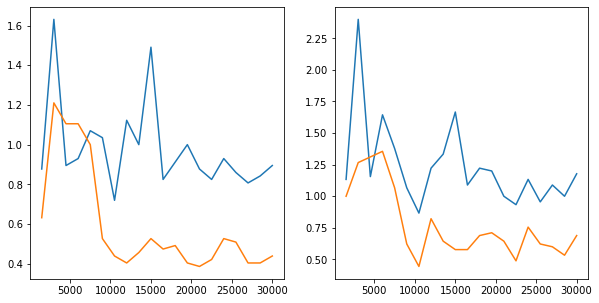

In [236]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(iters[0:], omega_df['151'].loc['NN_blanks'][[f'_start_mic:1_{n}' for n in iters[0:]]])
plt.plot(iters[0:], omega_df['151'].loc['NN_blanks'][[f'_start_mic:0_{n}' for n in iters[0:]]])
plt.subplot(122)
plt.plot(iters[0:], omega_df['150'].loc['NN_blanks'][[f'_start_mic:1_{n}' for n in iters[0:]]])
plt.plot(iters[0:], omega_df['150'].loc['NN_blanks'][[f'_start_mic:0_{n}' for n in iters[0:]]])

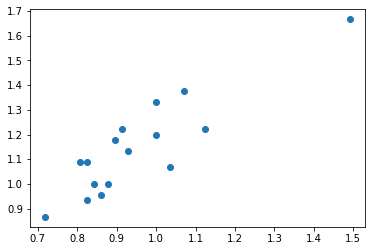

In [235]:
plt.scatter(omega_df['151'].loc['NN_blanks'][[f'_start_mic:1_{n}' for n in iters[4:]]], omega_df['150'].loc['NN_blanks'][[f'_start_mic:1_{n}' for n in iters[4:]]])

In [773]:
names = [k for k in df_dict['151'].keys()]
# del(names[2])
omega_df = DF(columns=pd.MultiIndex.from_product([['150','151','47'], names+['bench']]), index=['N','N_blanks', 'NN_blanks'])
omega_df.loc['N', '150']['bench'] = len(bench_150)
omega_df.loc['N_blanks', '150']['bench'] = sum(bench_150['gene'].str.contains('Blank'))
omega_df.loc['NN_blanks', '150']['bench'] = 1.
omega_df.loc['N', '151']['bench'] = len(bench_151)
omega_df.loc['N_blanks', '151']['bench'] = sum(bench_151['gene'].str.contains('Blank'))
omega_df.loc['NN_blanks', '151']['bench'] = 1.
omega_df.loc['N', '47']['bench'] = len(bench_47)
omega_df.loc['N_blanks', '47']['bench'] = sum(bench_47['gene'].str.contains('Blank'))
omega_df.loc['NN_blanks', '47']['bench'] = 1.

for n in ['150','151','47']:
    for j in names:
#         if j+f'_{n}' in df_dict[n]:
        exp_df = df_dict[n][j]
        omega_df.loc['N', n][j] = len(exp_df)
        omega_df.loc['N_blanks', n][j] = sum(exp_df['gene'].str.contains('Blank'))
        omega_df.loc['NN_blanks', n][j] = sum(exp_df.nsmallest(omega_df.loc['N', n]['bench'], 'score')['gene'].str.contains('Blank'))/omega_df.loc['N_blanks', n]['bench']

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().



<AxesSubplot:>

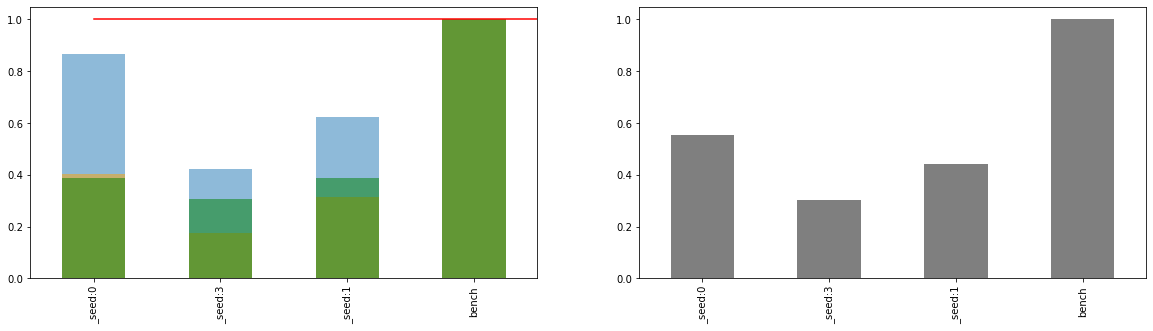

In [774]:
plt.figure(figsize=(20,5))
plt.subplot(121)
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')
plt.subplot(122)
omega_df.mean(level=1, axis=1).loc['NN_blanks'].plot.bar(alpha =0.5, color='black')

In [775]:
omega_df

150                                  151                      \
            _seed:0   _seed:3   _seed:1  bench   _seed:0   _seed:3   _seed:1   
N             37413     35115     31565  28689     47216     44654     40826   
N_blanks        109        69        53     45       110        77        54   
NN_blanks  0.866667  0.422222  0.622222    1.0  0.403509  0.175439  0.315789   

                        47                             
           bench   _seed:0   _seed:3   _seed:1  bench  
N          36464     84372     82436     77079  64242  
N_blanks      57       204       177       126     88  
NN_blanks    1.0  0.386364  0.306818  0.386364    1.0

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().



<AxesSubplot:>

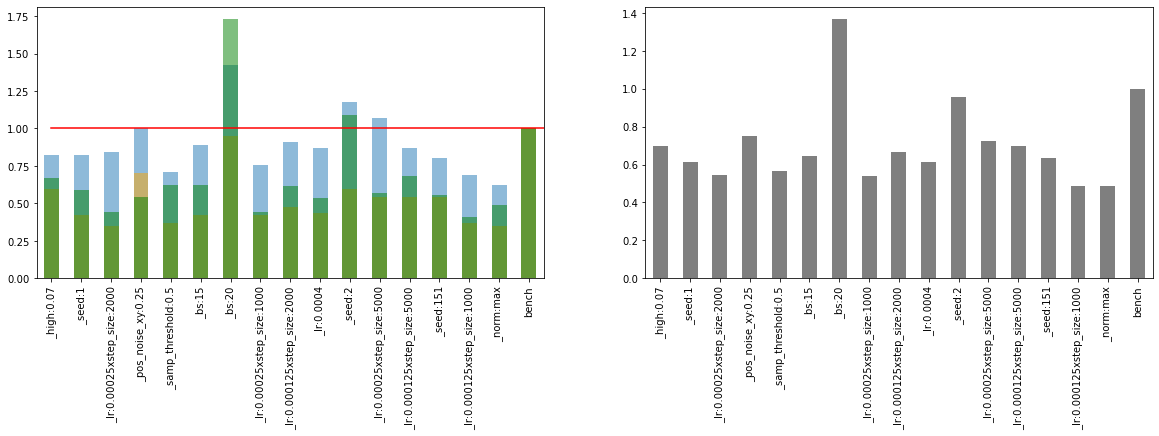

In [555]:
plt.figure(figsize=(20,5))
plt.subplot(121)
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')
plt.subplot(122)
omega_df.mean(level=1, axis=1).loc['NN_blanks'].plot.bar(alpha =0.5, color='black')

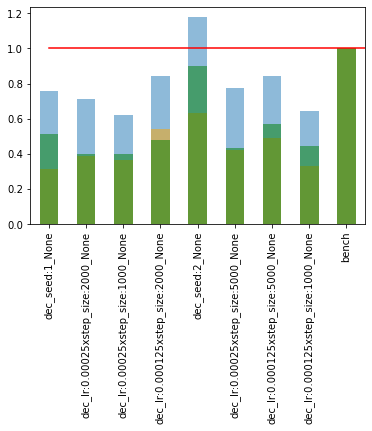

In [413]:
# plt.figure(figsize=(20,5))
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')

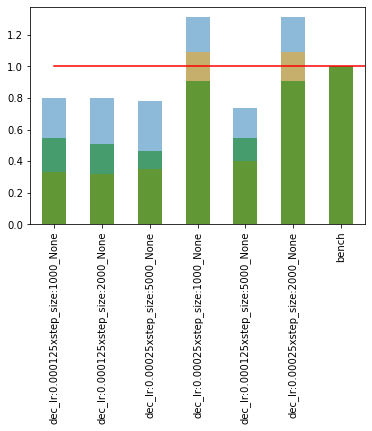

In [377]:
# plt.figure(figsize=(20,5))
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')

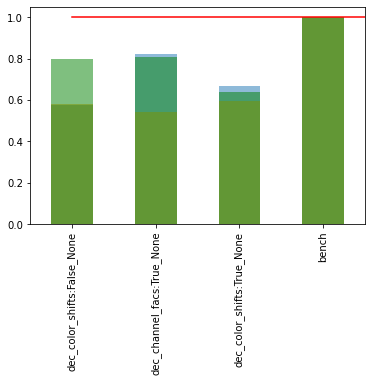

In [303]:
# plt.figure(figsize=(20,5))
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')

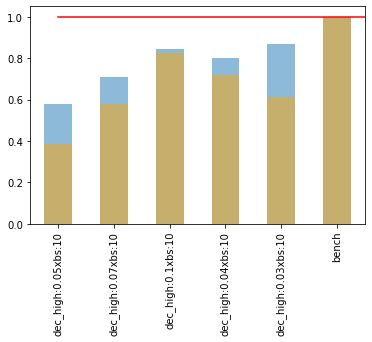

In [93]:
# plt.figure(figsize=(20,5))
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')

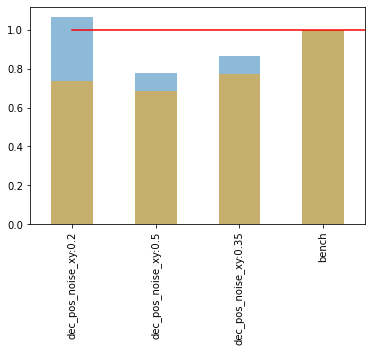

In [96]:
# plt.figure(figsize=(20,5))
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')

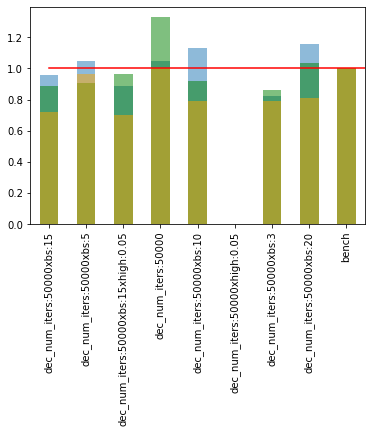

In [1142]:
# plt.figure(figsize=(20,5))
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')

In [730]:
 df_dict['151'].keys()

dict_keys(['_lr:0.000125xstep_size:1000', '_lr:0.000125xstep_size:2000', '_lr:0.00025xstep_size:5000', '_lr:0.00025xstep_size:1000', '_lr:0.000125xstep_size:5000', '_num_iters:9995', '_lr:0.00025xstep_size:2000'])

In [731]:
res_df = df_dict['151']['_num_iters:9995']

In [732]:
res_df

,loc_idx,frame_idx,code_inds,x,y,z,prob,x_sig,y_sig,z_sig,...,int_sig_18,int_19,int_sig_19,int_20,int_sig_20,int_21,int_sig_21,gene,zm,score
0,0,0,0,97684.600,33158.290,42.713226,0.568894,29.444906,22.567802,23.505379,...,0.873446,1.151892,0.873000,0.914779,0.510350,1.005311,0.731563,1700022I11Rik,42.713226,0.708542
1,2,0,0,103560.010,40100.223,83.542564,0.571688,16.228373,14.795343,15.078802,...,0.285387,0.829706,0.475631,0.546622,0.227148,0.740669,0.390903,1700022I11Rik,83.542564,0.500156
2,4,0,0,105243.080,105001.440,98.458954,0.729012,38.042240,48.025460,15.456263,...,0.668269,3.667477,1.572221,1.099843,0.368016,2.209449,0.870207,1700022I11Rik,98.458954,0.775187
3,5,0,0,81668.500,154777.450,64.132324,0.721411,23.993530,25.861866,23.356802,...,0.899662,2.589980,0.948435,2.213717,0.609020,7.126501,2.297566,1700022I11Rik,64.132324,0.603487
4,6,0,0,118748.230,181627.720,54.869460,0.732761,25.679296,17.731243,27.396330,...,0.825372,2.040573,1.054887,2.466381,0.648389,3.373567,1.395561,1700022I11Rik,54.869460,0.587936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52896,90664,6,250,19792.260,153981.920,74.979080,0.828731,20.189882,28.916550,20.657082,...,0.828569,3.588929,1.096150,4.773194,1.219166,2.819888,0.770570,Blank-9,74.979080,0.510181
52897,90665,6,250,95330.420,168471.620,62.234264,0.662264,21.271688,20.873910,19.237883,...,0.653177,2.019286,0.575921,1.964993,0.524159,1.922427,0.469913,Blank-9,62.234264,0.556791
52898,90667,6,251,157192.520,53994.620,87.510250,0.621337,33.641850,25.380102,20.780485,...,0.991788,0.124696,0.764773,0.838048,0.779857,2.342494,0.794079,Blank-10,87.510250,0.712870
52899,90669,6,251,17883.227,148628.560,84.476810,1.000000,38.101765,29.849634,22.811730,...,0.775673,0.953528,0.643180,1.558312,0.713703,1.604891,1.027197,Blank-10,84.476810,0.585117


In [733]:
res_single = remove_doublets(res_df)

In [473]:
_,matches,shift = matching(bench_151, res_df, tolerance=500, print_res=True, allow_multiple_matches=False)

Recall: 0.076
Precision: 0.059
Jaccard: 3.457
RMSE_vol: 69.830
Eff_3d: -2.662
FN: 33675.0 FP: 44209.0
Num. matches: 2789.000
Shift: 3.04,-2.24,-41.76


In [1029]:
_,matches,shift = matching(istd_151.nlargest(50000, 'quality'), res_df.nsmallest(50000, 'score'), tolerance=500, print_res=True, allow_multiple_matches=False)

Recall: 0.773
Precision: 0.773
Jaccard: 62.973
RMSE_vol: 54.398
Eff_3d: 54.056
FN: 11360.0 FP: 11360.0
Num. matches: 38640.000
Shift: -0.83,0.06,9.92


In [1150]:
_,matches,shift = matching(res_df, res_df2, tolerance=300, print_res=True, allow_multiple_matches=False)

Recall: 0.740
Precision: 0.855
Jaccard: 65.702
RMSE_vol: 35.131
Eff_3d: 61.466
FN: 30852.0 FP: 14923.0
Num. matches: 87688.000
Shift: -0.22,-0.05,-0.21


In [1151]:
len(matches)

87688

In [474]:
matches['score_pred'] = np.array(matches['score_pred'].values, dtype=np.float32)
matches['gene'] = matches['gene_pred']

36464 36500


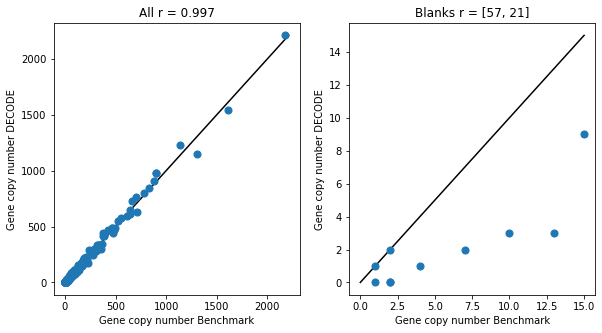

In [493]:
plot_gene_panels(res_df.nsmallest(36500, 'score'), bench_151, targets)

36464 36500


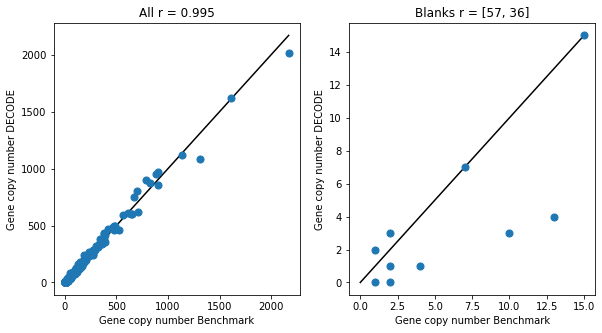

In [497]:
plot_gene_panels(istd_151.nlargest(36500, 'quality'), bench_151, targets)

36464 36500


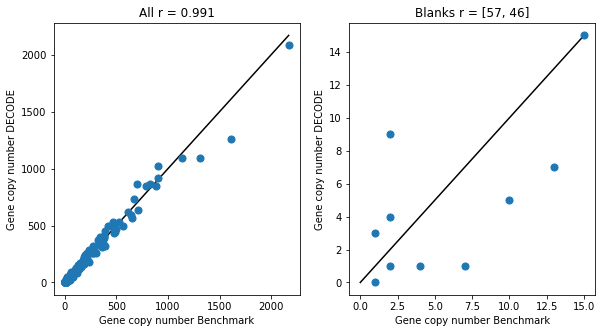

In [350]:
plot_gene_panels(res_df.nsmallest(36500, 'comb_sig'), bench_151, targets)

36464 41000


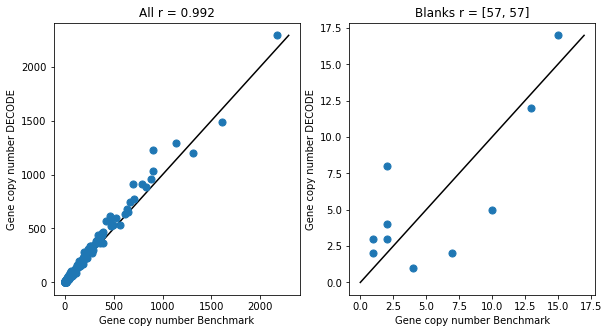

In [352]:
plot_gene_panels(res_df.nsmallest(41000, 'score'), bench_151, targets)

In [503]:
len(targets)

252

In [1055]:
fns = res_df2.loc[~res_df2['loc_idx'].isin(matches['loc_idx_tar'])]
tps = res_df2.loc[res_df2['loc_idx'].isin(matches['loc_idx_tar'])]
fps = res_df.loc[~res_df['loc_idx'].isin(matches['loc_idx_pred'])]
print(tps['gene'].str.contains('Blank').sum()/len(tps)*100)
print(fns['gene'].str.contains('Blank').sum()/len(fns)*100)
print(fps['gene'].str.contains('Blank').sum()/len(fps)*100)

0.48170336787564766
0.5972086984745212
0.6270232436058211


In [1030]:
fns = istd_151.loc[~istd_151['loc_idx'].isin(matches['loc_idx_tar'])]
tps = istd_151.loc[istd_151['loc_idx'].isin(matches['loc_idx_tar'])]
fps = res_df.loc[~res_df['loc_idx'].isin(matches['loc_idx_pred'])]
print(tps['gene'].str.contains('Blank').sum()/len(tps)*100)
print(fns['gene'].str.contains('Blank').sum()/len(fns)*100)
print(fps['gene'].str.contains('Blank').sum()/len(fps)*100)

0.11387163561076605
2.4536775421586414
1.5951352780470611


In [705]:
gene_counts = DF(data=None, index=targets)
gene_counts['dec'] = res_sub_s.groupby('gene')['gene'].count()
gene_counts['ist'] = bench_df.groupby('gene')['gene'].count()
gene_counts['tps'] = tps.groupby('gene')['gene'].count()
gene_counts['fps'] = fps.groupby('gene')['gene'].count()
gene_counts['fns'] = fns.groupby('gene')['gene'].count()
gene_counts = gene_counts.fillna(0)

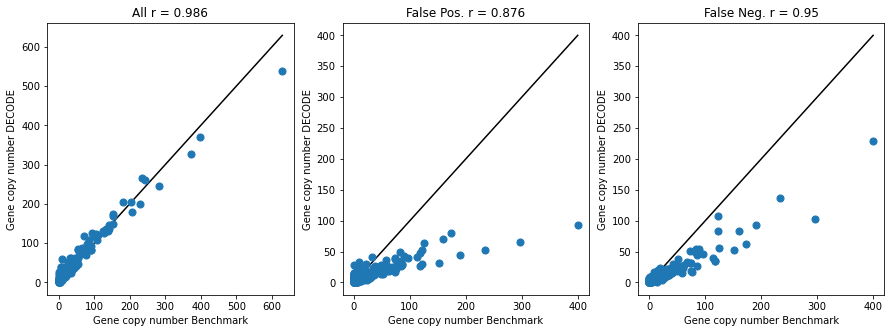

In [706]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plot_gene_numbers(gene_counts['ist'].values, gene_counts['dec'].values, 'All', log=False)
plt.subplot(132)
plot_gene_numbers(gene_counts['tps'].values, gene_counts['fps'].values, 'False Pos.', log=False)
plt.subplot(133)
plot_gene_numbers(gene_counts['tps'].values, gene_counts['fns'].values, 'False Neg.', log=False)

Text(0.5, 1.0, 'Corr. 0.954')

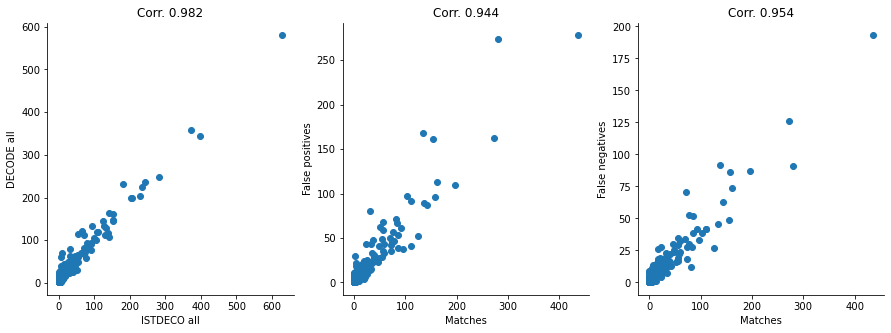

In [676]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(gene_counts['ist'].values, gene_counts['dec'].values)
plt.plot([0,0],[len(gene_counts['ist'].values),len(gene_counts['dec'].values)])
sns.despine()
plt.xlabel('ISTDECO all')
plt.ylabel('DECODE all')
plt.title('Corr. ' + str(np.corrcoef(gene_counts['ist'].values, gene_counts['dec'].values)[0,1])[:5])
plt.subplot(132)
plt.scatter(gene_counts['tps'].values, gene_counts['fps'].values)
sns.despine()
plt.xlabel('Matches')
plt.ylabel('False positives')
plt.title('Corr. ' + str(np.corrcoef(gene_counts['tps'].values, gene_counts['fps'].values)[0,1])[:5])
plt.subplot(133)
plt.scatter(gene_counts['tps'].values, gene_counts['fns'].values)
sns.despine()
plt.xlabel('Matches')
plt.ylabel('False negatives')
plt.title('Corr. ' + str(np.corrcoef(gene_counts['tps'].values, gene_counts['fns'].values)[0,1])[:5])


In [717]:
par_dict = {}
par_dict['istdeco'] = [istd_151, 'quality', False]
for i,k in enumerate(df_dict['151']):
#     if 'dec_' in k and '151' in k:
    if len(df_dict['151'][k]) > 0:
        par_dict[k] = [df_dict['151'][k], 'score', True]
    #         par_dict[k+'_s'] = [remove_doublets(df_dict[k].nsmallest(50000,'comb_sig')), 'comb_sig', True]

roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k], n_max=80000)
    roc_dict[k] = [x, y]

In [718]:
df = pd.DataFrame(columns=roc_dict.keys())
df['x'] = roc_dict[df.keys()[0]][0]
for k in roc_dict.keys():
    df[k] = roc_dict[k][1]

In [719]:
fig = px.line(df, x="x", y=list(roc_dict.keys()), range_y=[0,150], range_x=[0,80000], labels={"x": "Number genes","value":'Number blanks'})
fig.show()

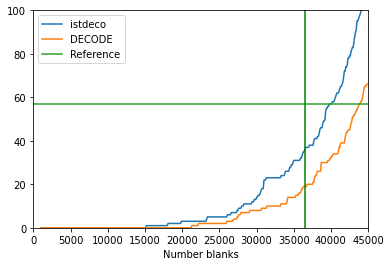

In [501]:
plt.plot(df['x'], df['istdeco'], label='istdeco')
plt.plot(df['x'], df['dec_lr:0.000125xstep_size:1000_None_151'], label='DECODE')
plt.plot([0,45000], [57,57], label='Reference')
plt.plot([36500,36500], [0,100], color='green')
plt.xlim(0,45000)
plt.ylim(0,100)
plt.xlabel('Number transcripts')
plt.xlabel('Number blanks')
plt.legend()

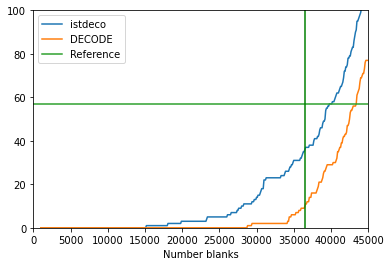

In [722]:
plt.plot(df['x'], df['istdeco'], label='istdeco')
plt.plot(df['x'], df['_seed:3'], label='DECODE')
plt.plot([0,45000], [57,57], label='Reference')
plt.plot([36500,36500], [0,100], color='green')
plt.xlim(0,45000)
plt.ylim(0,100)
plt.xlabel('Number transcripts')
plt.xlabel('Number blanks')
plt.legend()

In [569]:
res_df = df_dict['dec_enabled:Truexint_inf:per_channelxchannel_shifts:Truexchannel_facs:Truexn_foci_avg:1xseed:2']
int_m = [f'int_{i}' for i in range(4)]
int_s = [f'int_sig_{i}' for i in range(4)]
res_df['int_tot'] = res_df.loc[:,int_m].values.sum(-1)
res_df['int_sig_tot'] = res_df.loc[:,int_s].values.sum(-1)


metrics = ['comb_sig','int_tot','int_sig_tot', 'prob','zm']
bins = [np.linspace(0,1.5,31), np.linspace(0,50,31), np.linspace(0,20,31), np.linspace(0.4,1,31), np.linspace(0,100.,31)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_df[~res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_df[res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

KeyError: 'dec_enabled:Truexint_inf:per_channelxchannel_shifts:Truexchannel_facs:Truexn_foci_avg:1xseed:2'

In [299]:
res_df = df_dict['dec_enabled:Truexint_inf:per_channelxchannel_shifts:Truexchannel_facs:Truexn_foci_avg:1xseed:2'].nsmallest(10000, 'comb_sig')

In [290]:
code_cols = [plt.get_cmap('gist_ncar')(x) for x in np.linspace(0.,1.,140)]

In [291]:
import mpld3
from mpld3 import plugins

In [663]:
res_sub = df_dict['dec_psf_noise:0.0xrate_fac:3.0'].nsmallest(17000, 'comb_sig')
# res_sub = df_dict['dec_min_int_sig:0.0xint_fac:0.1'].nsmallest(15000, 'code_err')
ist_sub = istdeco_df.nlargest(15000, 'quality')
bench_sub = bench_df.nlargest(13800, 'total_magnitude')

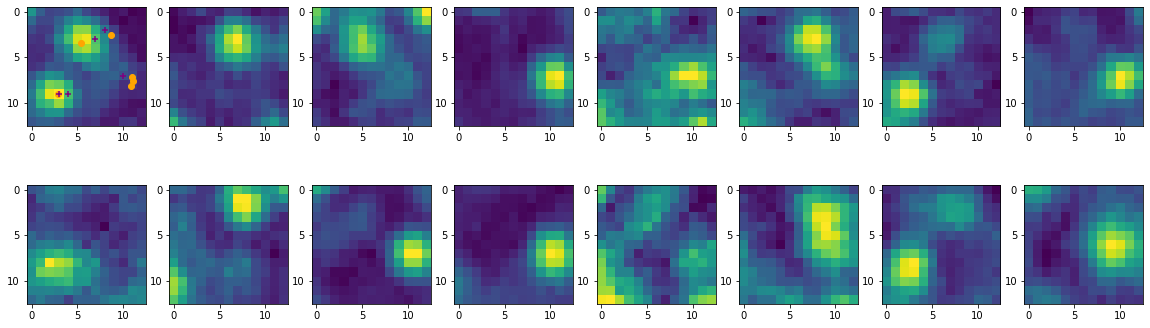

In [664]:
vol, crop = extract_roi(img_stack[None], torch.IntTensor([514,740,0]), 6, 8)

res_crop = crop_df(nm_to_px(res_sub), crop)
ist_crop = crop_df(nm_to_px(ist_sub), crop)

plt.figure(figsize=(20,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(vol[0,i])
    
    if not i:
        plt.scatter(res_crop['x'],res_crop['y'],color='orange')
        plt.scatter(ist_crop['x'],ist_crop['y'],color='purple', marker='+')

In [656]:
img_stack = read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images150.tif')[:,:,:,:,:]

In [657]:
img_stack.shape

torch.Size([1, 22, 7, 2048, 2048])

In [658]:
from decode_fish.funcs.dataset import GaussianSmoothing
filt = GaussianSmoothing(11, device='cpu')
img_filt = filt(img_stack)
img_stack -= img_filt

In [748]:
# res_df = df_dict['dec_enabled:Truexint_inf:per_channelxchannel_shifts:Truexchannel_facs:Truexn_foci_avg:1xseed:2'].nsmallest(10000, 'comb_sig')
# res_df = df_dict['dec_enabled:Truexint_inf:per_channelxchannel_shifts:Truexchannel_facs:Truexn_foci_avg:1xseed:2'].nsmallest(10000, 'comb_sig')
res_df = df_dict['150']['_num_iters:9995']#.nsmallest(30000, 'comb_sig')
# res_df = sel_int_ch(res_df, code_ref)

In [768]:
res_df['int_tot'] =  res_df[[f'int_{i}' for i in range(4)]].values.astype('float32').sum(-1)

In [749]:
def extract_roi(beads: torch.Tensor, coordinates, size_xy=5):
    res = []
    
    x, y, z = coordinates
    crop = np.s_[:,z, int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

In [750]:
z_vols = [[] for _ in range(20)]

In [765]:
int_keys = [f'int_{i}' for i in range(22)]

In [752]:
for i in tqdm(range(len(res_df))):
    b_loc = nm_to_px(res_df.iloc[i])
    vol, crop = extract_roi(img_stack[0], torch.IntTensor(np.array(b_loc.loc[['x','y','frame_idx']].values, dtype='float32')), 6)
    if vol.shape == torch.Size([22, 13, 13]):
        ints = b_loc[int_keys].values.astype('float32')
        volm = vol/ints[:,None,None]
        volm = cpu(volm[code_ref[b_loc['code_inds']].nonzero()[0]])
        z = np.clip(b_loc['z'],0,100)
        z_vols[int(b_loc['zm']/5)].append(volm)

100%|█████████████████████████████████████████████████████| 42892/42892 [00:57<00:00, 746.32it/s]


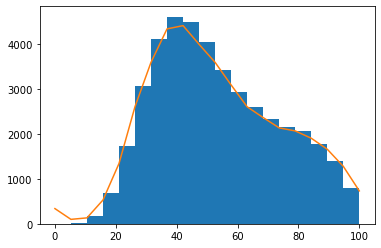

In [753]:
plt.hist(res_df['z'], bins=np.linspace(0,100,20))
plt.plot(np.linspace(0,100,20), [len(z) for z in z_vols])

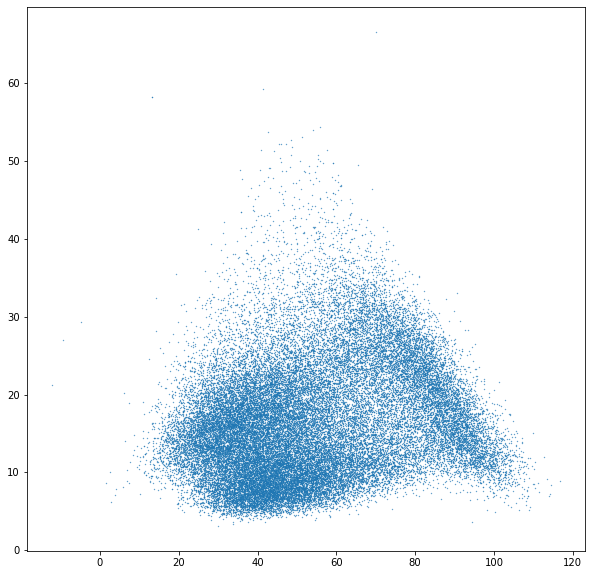

In [759]:
plt.figure(figsize=[10,10])
plt.scatter(res_df['z'], res_df['z_sig'], s=0.1)

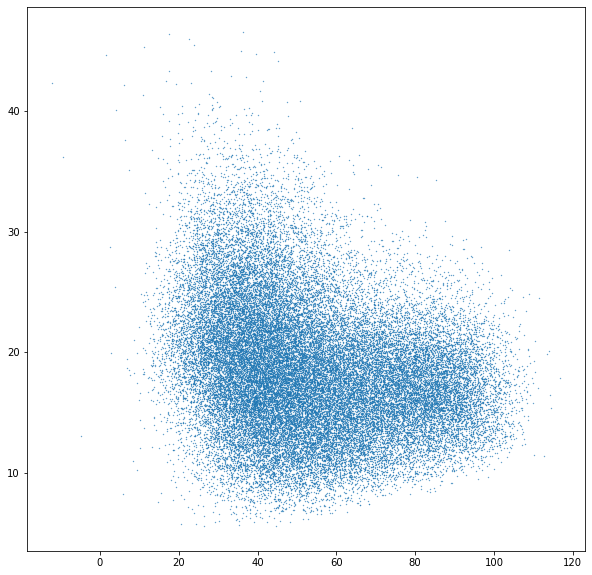

In [770]:
plt.figure(figsize=[10,10])
plt.scatter(res_df['z'], res_df['int_tot'], s=0.1)

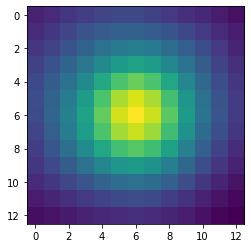

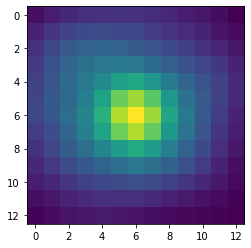

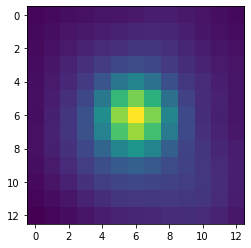

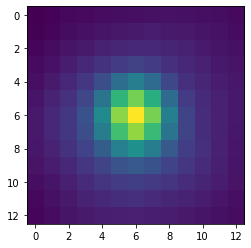

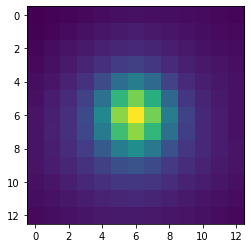

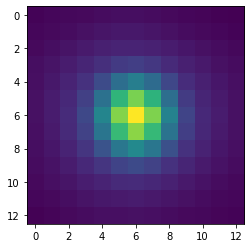

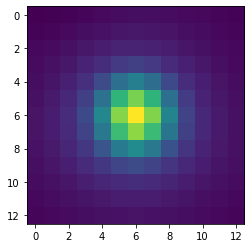

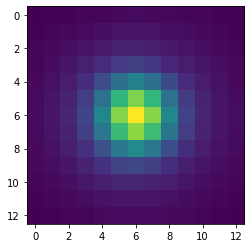

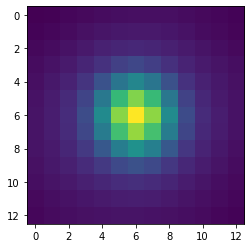

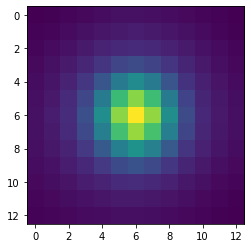

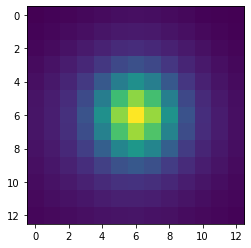

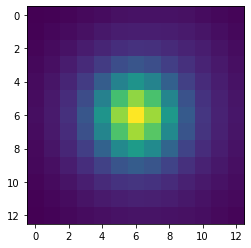

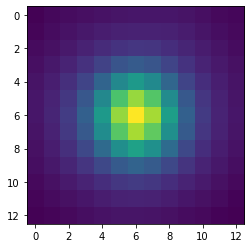

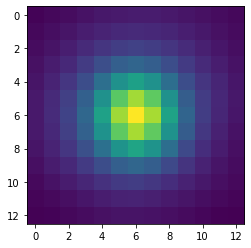

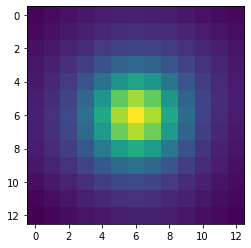

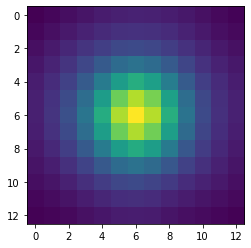

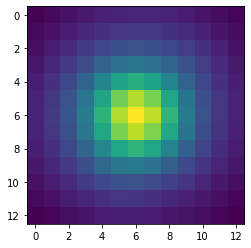

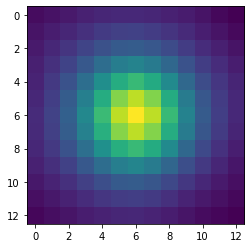

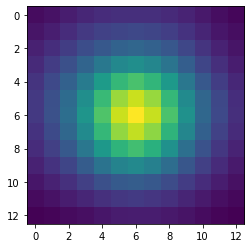

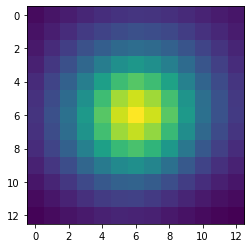

In [754]:
psf_vol = []
for i in range(len(z_vols)):
    mvol = np.stack(z_vols[i])
    mvol = mvol.reshape(-1, mvol.shape[-2], mvol.shape[-1])
    psf_vol.append(mvol.mean(0)/mvol.mean(0).max())
    plt.imshow(mvol.mean(0))
    plt.show()

In [755]:
psf_vol = np.stack(psf_vol)

(<Figure size 1139.82x1096.62 with 6 Axes>,
 [<AxesSubplot:ylabel='y'>,
  <AxesSubplot:xlabel='x', ylabel='z'>,
  <AxesSubplot:xlabel='z'>])

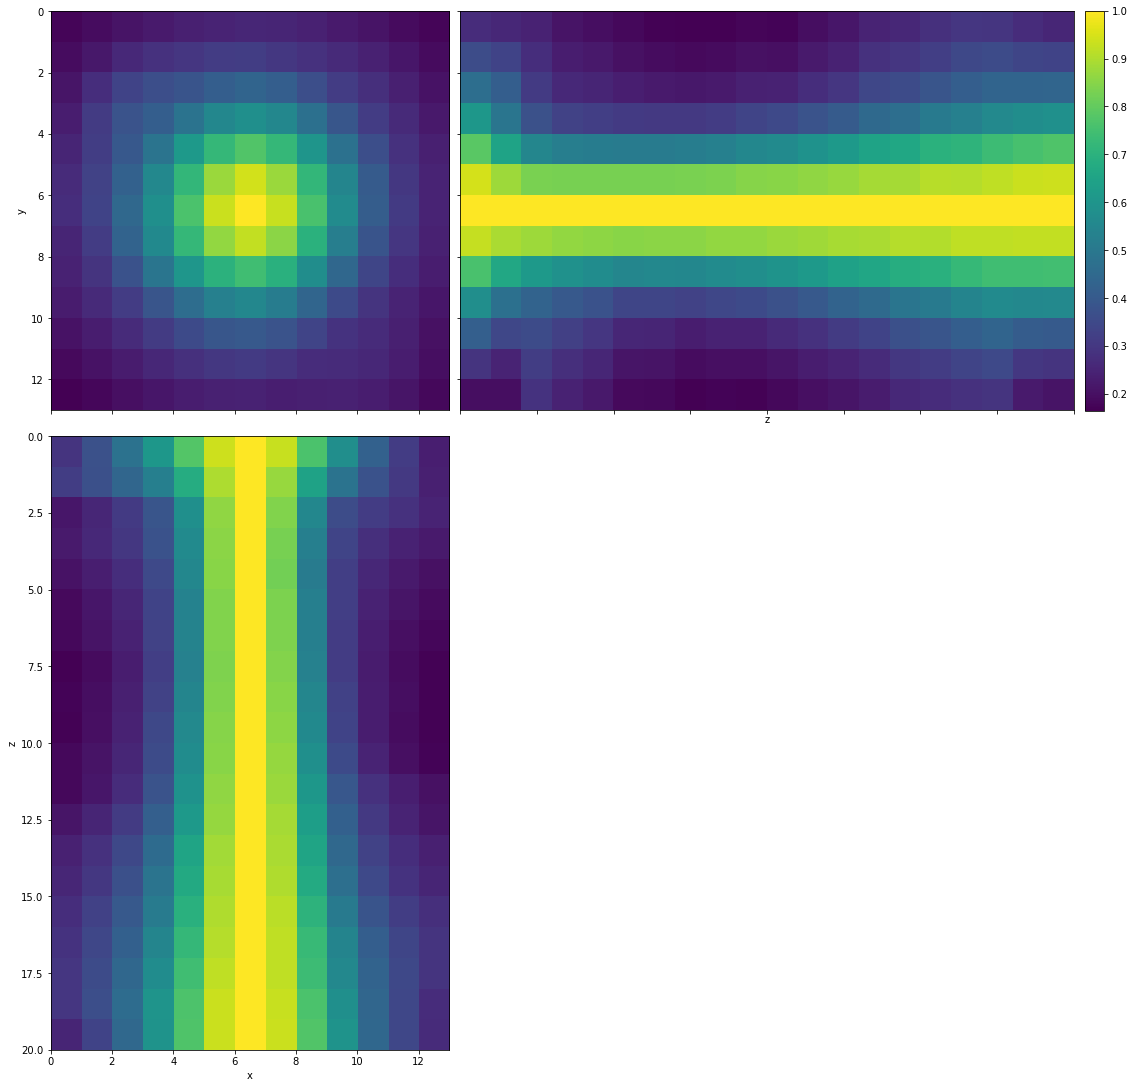

In [756]:
plot_3d_projections(psf_vol)

21392


(600.0, 750.0)

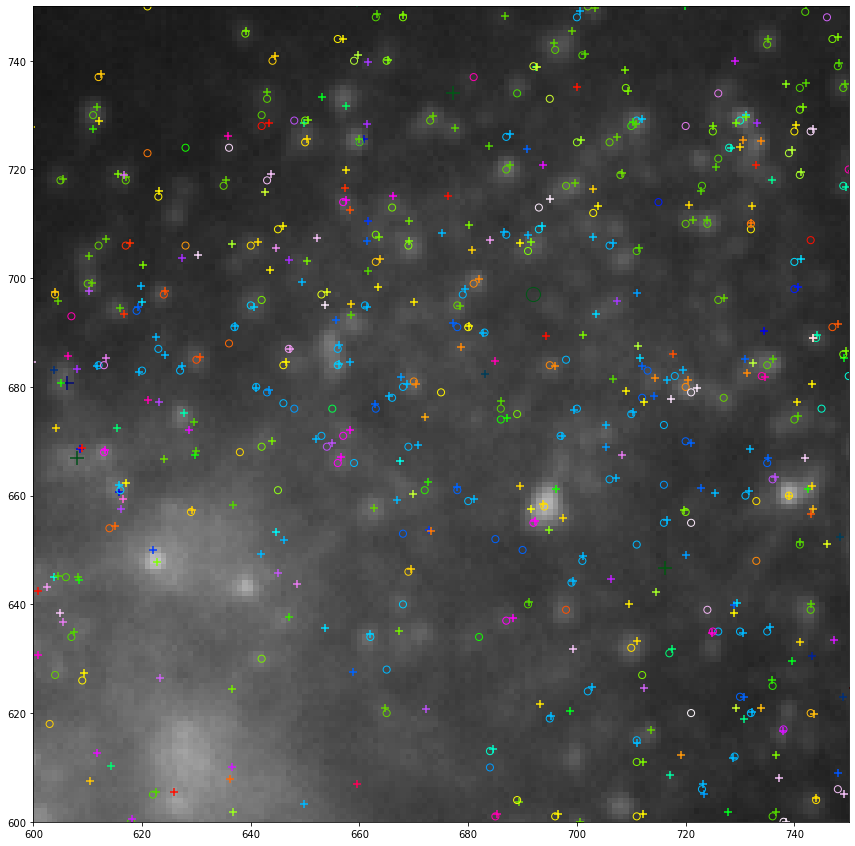

In [63]:
ind = 0
img = load_tiff_image(image_paths[ind])
preds_px = nm_to_px(res_single)#[res_df['gene']!='MALAT1']
bench_px = nm_to_px(ist_sub)#[bench_df['gene']!='MALAT1']
print(len(preds_px))
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img[0,0], cmap='gray')

for i in range(len(targets)):
    
    preds_sub = preds_px[preds_px['code_inds'] == i]
    bench_sub = bench_px[bench_px['code_inds'] == i]
    
    size = 200. if 'Blank' in targets[i] else 50.

    ax.scatter(bench_sub['x'],bench_sub['y'], color=code_cols[i], s=size, marker='o', facecolor='none')
    ax.scatter(preds_sub['x'],preds_sub['y'], color=code_cols[i], s=size, marker='+')

ax.set_xlim(600,750)
ax.set_ylim(600,750)

# plugins.connect(fig, plugins.MousePosition(fontsize=14))
# mpld3.display()

In [409]:
def extract_roi(beads: torch.Tensor, coordinates, size_xy=5, size_z=10):
    res = []
    
    x, y, z = coordinates
    crop = np.s_[:,int(z):int(z+1), int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

# Analyze blanks

26


,loc_idx,frame_idx,code_inds,x,y,z,prob,x_sig,y_sig,z_sig,...,int_1,int_2,int_3,int_sig_0,int_sig_1,int_sig_2,int_sig_3,zm,int_tot,int_sig_tot
28421,28421,0,243,383.26723,68.88303,2.376363,0.658758,17.744606,23.340118,8.481233,...,5.209935,6.694495,8.023641,1.996939,1.568243,3.390814,3.319344,37.63626,26.435554,10.275341


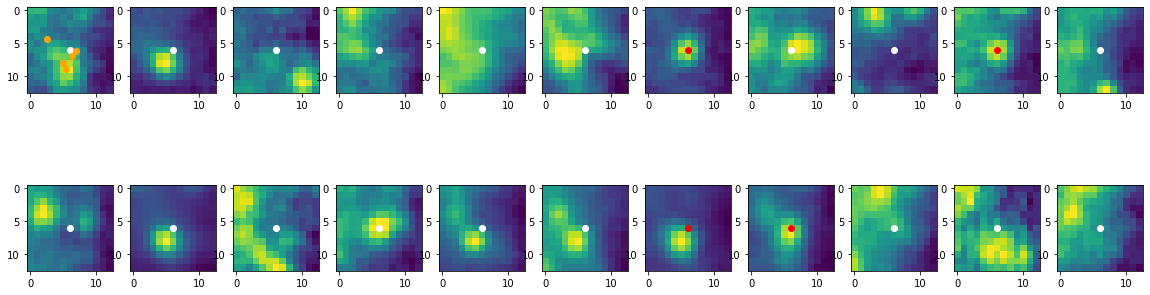

In [422]:
# Random predictions 
res_sub = res_df.nsmallest(20000, 'comb_sig')
# Random blank 
sub = res_sub[res_sub['gene'].str.contains('Blank')]

ind = np.random.randint(0, len(sub))
print(ind)

b_loc = nm_to_px(sub.iloc[ind])
display(DF(b_loc).T)
vol, crop = extract_roi(img_stack, torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 6, 8)

res_crop = crop_df(nm_to_px(res_sub), crop)
bench_crop = crop_df(nm_to_px(bench_df), crop)

plt.figure(figsize=(20,6))
for i in range(22):
    plt.subplot(2,11,i+1)
    plt.imshow(vol[i,0])
    color = 'red' if code_ref[list(targets).index(b_loc['gene'])][i] else 'white'
    plt.scatter([6],[6], color=color)
    
#     plt.title(str(np.round(b_loc[f'int_{i}'], 3)) + ' +- ' + str(np.round(b_loc[f'int_sig_{i}'], 3)))
    
    if not i:
        plt.scatter(res_crop['x'],res_crop['y'],color='orange')
        plt.scatter(bench_crop['x'],bench_crop['y'],color='purple', marker='+')

In [677]:
fn_inds = fns['loc_idx'].values

In [678]:
len(res_df)

15020

In [679]:
res_sub = res_df.nsmallest(10000, 'comb_sig')

,loc_idx,x,y,z,gene,frame_idx,code_inds
5894569,5894569,90.023502,729.022581,2.304147,Pdgfc,0,152


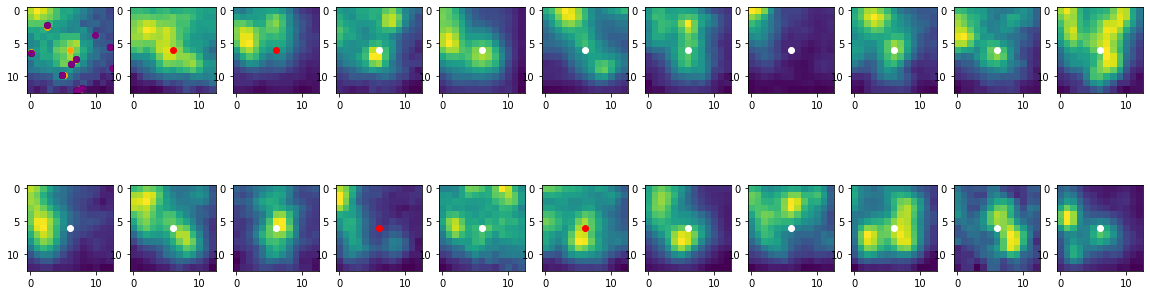

In [681]:
ind = np.random.randint(0, len(fn_inds))
ind = fn_inds[ind]

b_loc = nm_to_px(bench_df[bench_df['loc_idx'] == ind], px_size_zyx=[120.0, 100.0, 100.0]).iloc[0]

display(DF(b_loc).T)
vol, crop = extract_roi(img_stack, torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 6, 8)

cropb = crop_df(nm_to_px(bench_df, px_size_zyx=[120.0, 100.0, 100.0]), crop)
cropr = crop_df(nm_to_px(res_sub), crop)
cropf = crop_df(nm_to_px(res_df), crop)

plt.figure(figsize=(20,6))
for i in range(22):
    plt.subplot(2,11,i+1)
    plt.imshow(vol[i,0])
    color = 'red' if code_ref[list(targets).index(b_loc['gene'])][i] else 'white'
    plt.scatter([6],[6], color=color)
    
    if not i:
        plt.scatter(cropb['x'],cropb['y'],color='orange')
        plt.scatter(cropr['x'],cropr['y'],color='black')
        plt.scatter(cropf['x'],cropf['y'],color='purple')

In [545]:
cropb

,loc_idx,x,y,z,gene,frame_idx,code_inds
5911774,5911774,6.497235,6.030876,0.760369,Olfm3,0,144


In [382]:
res_df = remove_doublets(df_dict['dec_num_iters:100000xenabled:False'])

In [383]:
keys = ['x_sig','y_sig','z_sig','prob','int_0', 'int_1', 'int_2', 'int_3', 'int_sig_0', 'int_sig_1', 'int_sig_2', 'int_sig_3', 'zm']
res_df['class'] = res_df['gene'].str.contains('Blank')*1

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [384]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

X = np.concatenate([res_df.nsmallest(10000,'comb_sig')[keys].values, res_df[res_df['class'] == 1][keys].values])
y = np.concatenate([res_df.nsmallest(10000,'comb_sig')['class'].values, res_df[res_df['class'] == 1]['class'].values])
 
clf = LogisticRegression(random_state=0,max_iter=10000).fit(X, y)

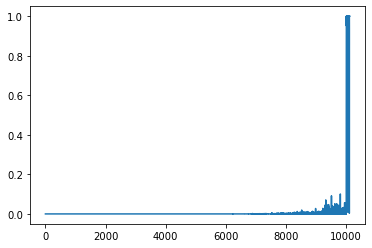

In [385]:
plt.plot(clf.predict_proba(X)[:,1])

In [386]:
# res_df = remove_doublets(df_dict['dec_num_iters:100000xenabled:False'])
res_df = remove_doublets(df_dict['dec_start_mic:30000xpsf_vol:Truextheta_par:Truexlr:0.0004'])
X = res_df[keys]

In [387]:
res_df['score'] = clf.predict_proba(X)[:,1]

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



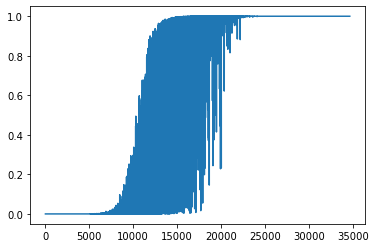

In [388]:
plt.plot(res_df.nsmallest(50000, 'comb_sig')['score'].values)

In [256]:
par_dict = {}

par_dict['comb_sig'] = [res_df, 'comb_sig', True]
par_dict['score'] = [res_df, 'score', True]

In [257]:
roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k], n_max=50000)
    roc_dict[k] = [x, y]

In [258]:
df = pd.DataFrame(columns=roc_dict.keys())
df['x'] = roc_dict[df.keys()[0]][0]
for k in roc_dict.keys():
    df[k] = roc_dict[k][1]

In [259]:
fig = px.line(df, x="x", y=list(roc_dict.keys()), range_y=[0,100], range_x=[0,50000], labels={"x": "Number genes","value":'Number blanks'})
fig.show()

In [378]:
df_dict['151'].keys()

dict_keys(['dec_lr:0.000125xstep_size:1000_None_151', 'dec_lr:0.000125xstep_size:2000_None_151', 'dec_lr:0.00025xstep_size:5000_None_151', 'dec_lr:0.00025xstep_size:1000_None_151', 'dec_lr:0.000125xstep_size:5000_None_151', 'dec_lr:0.00025xstep_size:2000_None_151'])

In [379]:
res_df = df_dict['151']['dec_lr:0.000125xstep_size:1000_None_151'].nsmallest(35000, 'score')

In [400]:
def sel_int_ch(res_df, codebook):
    
    int_m = [f'int_{i}' for i in range(codebook.shape[1])]
    int_s = [f'int_sig_{i}' for i in range(codebook.shape[1])]
    
    int_arr = res_df.loc[:,int_m].values
    int_sig = res_df.loc[:,int_s].values
    
    int_arr[codebook[res_df['code_inds'].values] == 0] = 0.
    int_sig[codebook[res_df['code_inds'].values] == 0] = 0.
    
#     print(int_arr.shape)
    
    ret_df = res_df.drop(columns=int_m)
    ret_df = ret_df.drop(columns=int_s)
    
    ret_df[int_m] = int_arr
    ret_df[int_s] = int_sig

    return ret_df

In [381]:
int_arr = sel_int_ch(res_df.nsmallest(50000,'score'), code_ref)[[f'int_{i}' for i in range(code_ref.shape[1])]].values

In [382]:
int_arr.shape

(35000, 22)

In [383]:
means2 = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]

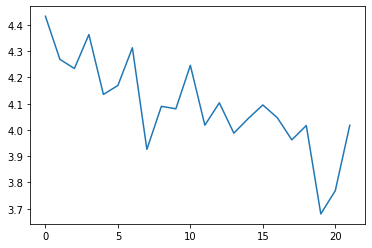

In [385]:
plt.plot(means2)
# plt.plot(means3)

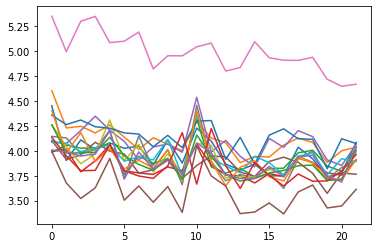

In [461]:
for k in df_dict['151'].keys():
    res_df = df_dict['151'][k].nsmallest(35000, 'score')    
    int_arr = sel_int_ch(res_df.nsmallest(50000,'score'), code_ref)[[f'int_{i}' for i in range(code_ref.shape[1])]].values
    means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
    plt.plot(means, label=k)
# plt.legend()

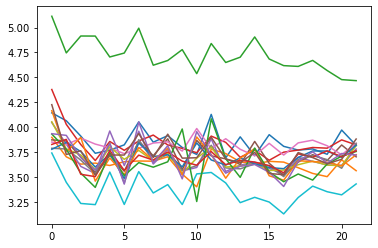

In [462]:
for k in df_dict['150'].keys():
    res_df = df_dict['150'][k].nsmallest(30000, 'score')    
    int_arr = sel_int_ch(res_df, code_ref)[[f'int_{i}' for i in range(code_ref.shape[1])]].values
    means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
    plt.plot(means, label=k)
# plt.legend()

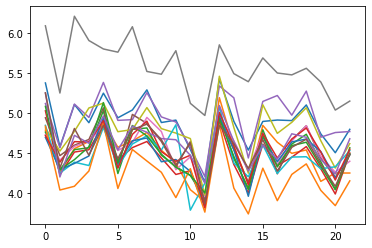

In [463]:
for k in df_dict['47'].keys():
    res_df = df_dict['47'][k].nsmallest(30000, 'score')    
    int_arr = sel_int_ch(res_df, code_ref)[[f'int_{i}' for i in range(code_ref.shape[1])]].values
    means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
    plt.plot(means, label=k)
# plt.legend()